In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# Load Fashion MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Add channel dimension
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Add Gaussian Noise for denoising autoencoder
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Encoder
def build_encoder():
    inputs = tf.keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2), padding='same')(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2,2), padding='same', name='bottleneck')(x)
    return tf.keras.Model(inputs, encoded, name='encoder')

# Decoder
def build_decoder():
    encoded_input = tf.keras.Input(shape=(4, 4, 128))
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(encoded_input)
    x = layers.UpSampling2D((2,2))(x) # 8x8x128
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x) # 16x16x64
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2,2))(x) # 32x32x32
    x = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x) # Still 32x32x1
    decoded = layers.Cropping2D(cropping=((2, 2), (2, 2)))(x) # Crop 2 pixels from each side to get 28x28

    return tf.keras.Model(encoded_input, decoded, name='decoder')


# Build models
encoder = build_encoder()
decoder = build_decoder()

autoencoder_input = tf.keras.Input(shape=(28,28,1))
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)

autoencoder = tf.keras.Model(autoencoder_input, decoded_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Early Stopping
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.3791 - val_loss: 0.2997 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2961 - val_loss: 0.2921 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2889 - val_loss: 0.2884 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2850 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2829 - val_loss: 0.2840 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2814 - val_loss: 0.2832 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.2803 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2798 - val_loss: 0.2813 - learning_rate: 0.0010
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2784 - val_loss: 0.2807 - learning_rate: 0.0010
Epoch 10

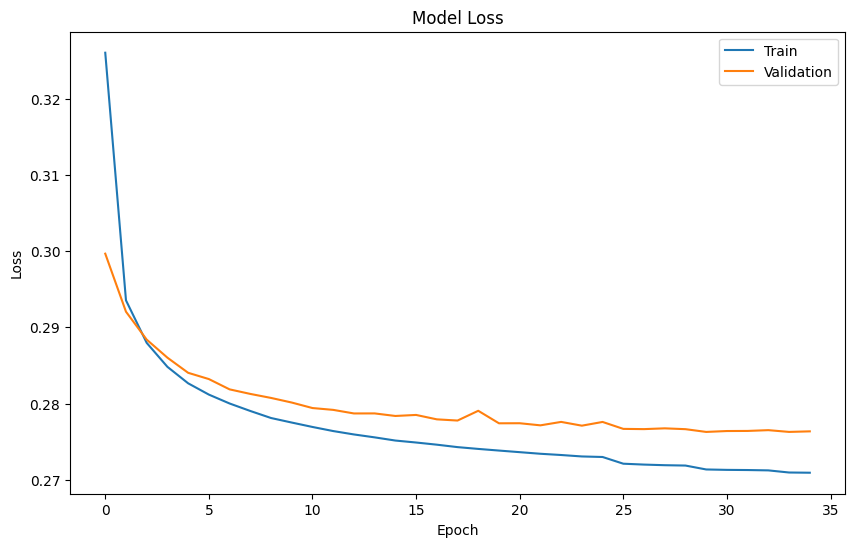

In [ ]:
# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Obtain latent space representation
Use the trained encoder model to predict the latent space representation of a subset of the test images.


In [ ]:
num_images_to_encode = 5000
subset_x_test_noisy = x_test_noisy[:num_images_to_encode]
encoded_imgs = encoder.predict(subset_x_test_noisy)
print(f"Shape of encoded_imgs: {encoded_imgs.shape}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of encoded_imgs: (5000, 4, 4, 128)


## Visualize latent space

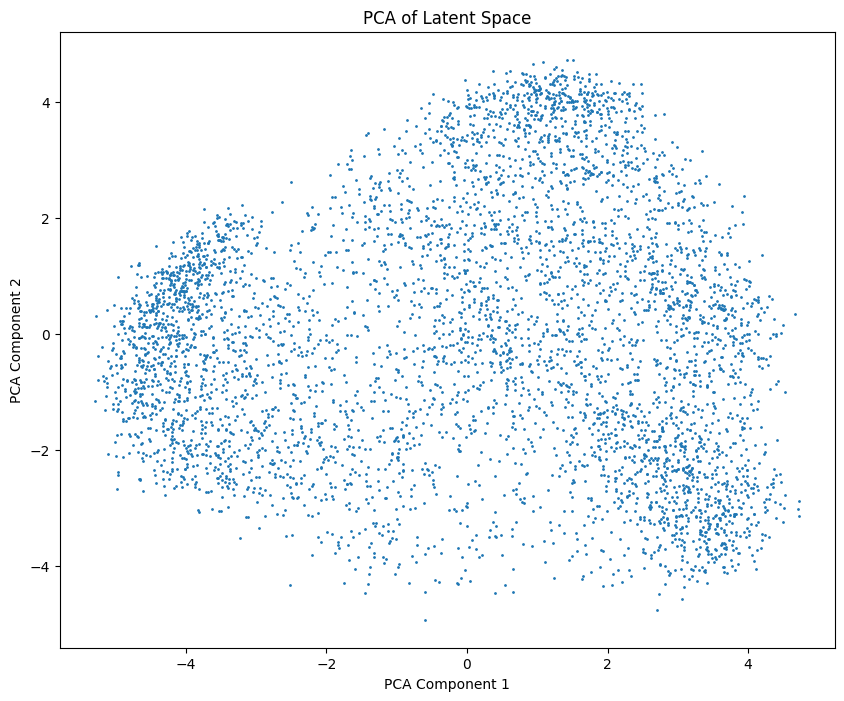

In [ ]:
encoded_imgs_reshaped = encoded_imgs.reshape(num_images_to_encode, -1)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
encoded_imgs_pca = pca.fit_transform(encoded_imgs_reshaped)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.scatter(encoded_imgs_pca[:, 0], encoded_imgs_pca[:, 1], s=1)
plt.title('PCA of Latent Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

## Summary:
*   The latent space representations for 5000 noisy test images were obtained, resulting in an array of shape (5000, 4, 4, 128).
*   PCA was applied to reduce the dimensionality of the latent space to 2 components for visualization purposes.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


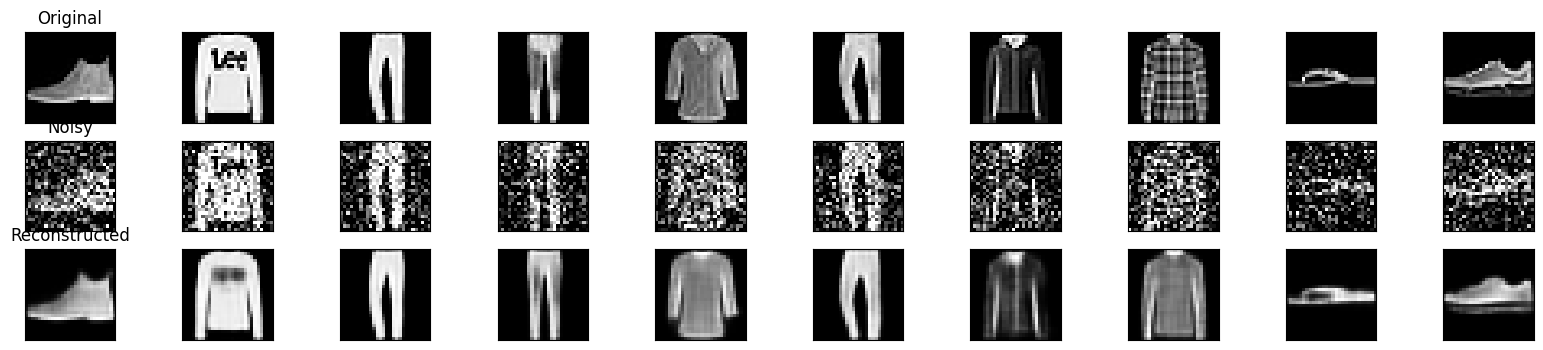

In [ ]:
# Select a few test images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original")


    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Noisy")

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    # Predict the reconstruction for the current image
    reconstructed_img = autoencoder.predict(x_test_noisy[i:i+1])
    plt.imshow(reconstructed_img[0].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Reconstructed")

plt.show()

### Data Analysis Key Findings

* The autoencoder was successfully trained to denoise Fashion MNIST images corrupted with Gaussian noise.
* The training and validation loss curves show that the model converged and the `EarlyStopping` callback prevented overfitting by restoring the best weights. The `ReduceLROnPlateau` callback also helped in fine-tuning the training by reducing the learning rate when the validation loss plateaued.
* The visualization of original, noisy, and reconstructed images demonstrates the autoencoder's ability to remove noise and reconstruct the original images, although some artifacts may still be present.
* The latent space representations for a subset of the test images were obtained, resulting in an array of shape (5000, 4, 4, 128).
* PCA was applied to reduce the dimensionality of the latent space to 2 components for visualization purposes.